The following code is used to figure out what the kernel and transmissibility constant should be when the number of farms in the outbreak is 1000, and the grid size is 50x50km. This grid set-up is a little more realistic, and may help understand the dynamics better than when I used 200 farms on a 5x5km grid. It seems that the Cauchy kernel with the transmissibility constant raised to the negative sixth power is the best combination. For complete list of tested combinations and figures refer to, "MakingGridBigger1_10_16.doc"

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


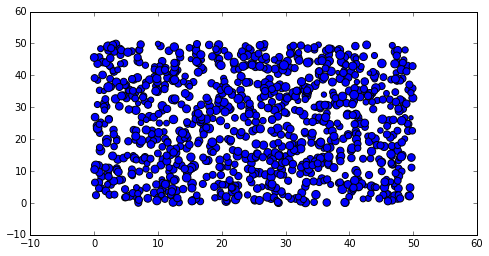

In [1]:
import numpy as np
from random import randint
Size = 50
N = 1000 
np.random.seed(53080)
x = Size*np.random.rand(N)
np.random.seed(23003)
y = Size*np.random.rand(N)  

#The cows and sheep are semi-normally distributed
#There can't be negative numbers so an absolute value is taken 
Cows = abs(np.ceil(np.random.normal(262.5,75,1000)))

Sheep = abs(np.ceil(np.random.normal(262.5,75,1000)))

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.scatter(x,y,s=(Cows+Sheep)/10)


In [2]:
#Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
    #Returns a number from 1 to griddim^2
    return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

In [3]:
def Kernel(dist_squared):
    dist_squared = np.asarray(dist_squared)
    is_scalar = False if dist_squared.ndim > 0 else True
    dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
    P = np.array([-9.2123*10**(-5),  9.5628*10**(-4),3.3966*10**(-3), -3.3687*10**(-2),-1.30519*10**(-1), -0.609262, -3.231772])
    K = np.exp(np.polyval(P,dist_squared))
    K[(dist_squared < 0.0138)] = 0.3093
    K[(dist_squared > 60*60)] = 0
    return(K if not is_scalar else K[0])

In [3]:
#def Kernel(dist_squared):
#    dist_squared = np.asarray(dist_squared)
#   is_scalar = False if dist_squared.ndim > 0 else True
#    dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
#    K = 1 / (pi * (1 + dist_squared**2))
#    K[(dist_squared < 0.0138)] = 0.3093
#    K[(dist_squared > 60*60)] = 0
#    return(K if not is_scalar else K[0])

In [4]:
from math import pi
def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
    Event = 0*Status
    INF = np.where(Status>5)[0]
    NI = INF.size # Note reported farms still infectious
    IGrids = grid[INF]-1
        
    for ii in range(NI):
        INFi = INF[ii]
        trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
        maxr = MaxRate[IGrids[ii]-1,:] #max number of animals to be infected in infected grid square
        # Elementwise multiplication
        rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
        MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
        rng = np.random.rand(len(MaxProb))
        m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
        for n in range(len(m)):
            s = 1
            M = m[n]
            PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
            if (PAB == 1):
                # Calculate the infection probability for each farm in the susceptible grid
                leng = last_in_grid[M]-first_in_grid[M]+1
                R = np.random.rand(leng)
                for j in range(leng):
                    ind1 = first_in_grid[M]+j-1
                    Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1])**2+(y[INFi]-y[ind1])**2))
                    if ((R[j] < Q) & (Status[ind1] == 0)):
                        Event[ind1] = 1
            else:
                R = np.random.rand(Num[M])
                # Loop through all susceptible farms in the grids where an infection event occurred.  
                for j in range(Num[M]):
                    P = 1 - s*(1 - PAB)**(Num[M] - j)
                    if (R[j] < (PAB / P)):
                        s = 0
                        ind1=first_in_grid[M]+j-1
                        Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1])**2+(y[INFi]-y[ind1])**2))
                        if ((R[j]< Q/P) & (Status[ind1] == 0)):
                            Event[ind1] = 1
    # Evolve the infection process of those farms which have been exposed and already infectious ones.  
    Status[Status > 0] += 1
    Status = Status + Event
    #m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
    #for i in range(len(m)):
    #    Status[m[i]]=-1;
    return {'Status':Status,'NI':NI}

In [5]:
def Outbreaks(Size,N,Y0,farms,end,end2,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    
    Status = np.array([0]*N)    #Initial Status of each farm
    init_ind = np.random.randint(0,N)
    for i in range(Y0):
        Status[init_ind] = 6 #one farm is initially infected 

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e3*Sheep + 7.7e3*Cows 

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    #i = np.argsort(grid) #get indexed values after sort
    i = [i[0] for i in sorted(enumerate(grid), key=lambda x:x[1])]
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Transmiss = Transmiss[i]
    Suscept = Suscept[i]
    Cows = Cows[i]
    Sheep = Sheep[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    index_inf = np.where(Status==6)[0].astype(int)
    m2 = np.array(np.where(grid==1))
    
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max())
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)
    
    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    
    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))):
        for j in range(1,int(max(grid))):
            if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
                MaxRate[i-1,j-1] = np.inf
            else:
                Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
                MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<end, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
       
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if np.logical_or((E[-4]+I[-4]==0),I == N):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full
   
    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (no_this[:,2]>5).astype(int)
    
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[index_inf][0],coords[index_inf][1]))
    dist = []
    for j in range(0,N):
        b = np.array((coords[j][0],coords[j][1]))
        dist.append(np.linalg.norm(b-index))
    to_return = np.c_[no_this[:,1],Status_ind,Status,dist,Cows,Sheep,x,y,Suscept,Transmiss]
    
    from scipy import spatial
    #Extract the infected farms
    inf_farms = to_return[to_return[:,1]==1]
    coords = list(zip(x,y))
    #Create list of coordinates infected farms
    inf_farm_coords = list(zip(inf_farms[:,6],inf_farms[:,7]))
    list_of_inf_coords = [list(elem) for elem in inf_farm_coords]
    #Create list of coordinates of all farms
    list_of_coords = [list(elem) for elem in coords]
    #Calculate Euclidean distance from each farm to all infected farms- each row in matrix represents
        #distance of one farm to each infected farm
    dist_to_inf = spatial.distance_matrix(list_of_coords,list_of_inf_coords)
    #Find distance to closest infected farm
    def minval(array):
        #return(np.min(array[np.nonzero(array)]))
        return(np.min(array))
    closest_infected = np.apply_along_axis(minval,1,dist_to_inf)
    average_infected = np.apply_along_axis(np.mean,1,dist_to_inf)
    to_return = np.c_[to_return,closest_infected,average_infected]
    
    #Create list of number of Cows and number of sheep for infected farms
    inf_farm_cows = list(inf_farms[:,4])
    inf_farm_sheep = list(inf_farms[:,5])
    #Create a function that extracts farm size based on closest infected farm
    def where_minval(array):
        #return(np.argmin(array[np.nonzero(array)]))
        return(np.argmin(array))
    closest_infected_size_ind = np.apply_along_axis(where_minval,1,dist_to_inf)
    closest_infected_cows = [inf_farm_cows[i] for i in closest_infected_size_ind]
    closest_infected_sheep = [inf_farm_sheep[i] for i in closest_infected_size_ind]

    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep,x,y,,disttoclosestinf,avgdisttoinf,#cowsinclosestiffarm,#sheepinclosestinffarm
    to_return = np.c_[to_return,closest_infected_cows,closest_infected_sheep]
    
    #Now run the outbreak for the additional end - end2 steps
    while(np.logical_and(t[-1]<end2, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
    
    
    newstatus = Status
    newstatus_ind = np.array([i>5 for i in Status]).astype(int)
    
    
    return([S,E,I,newstatus,newstatus_ind])
    #Return only the data where a farm was not infected by the "end" day
    #not_inf = to_return[to_return[:,1]==0]
    #append the status of these farms after the additional end2 - end days
    #newstatus = [Status[i] for i in not_inf[:,0]-1]
    #newstatus_ind = np.array([i>5 for i in newstatus]).astype(int)
    #final = np.c_[not_inf,newstatus_ind]
    
    #Determine the Status
    newstatus = Status
    newstatus_ind = np.array([i>5 for i in Status]).astype(int)
    final = np.c_[to_return,newstatus_ind,newstatus]
    
    #the following 16 variables are returned: farmID, Statusind, RawStatus,distance, cows, sheep, x, y, suscept,transmiss, distance to nearest infected, average distance to infected,#cows at nearest infected, #sheep at nearest infected,newstatusind, rawnewstatus
    #return([final,grid,first_in_grid,last_in_grid,Num,MaxRate])
    #return([final,to_return])
    
#test = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=25,end2=50,x=x,y=y,Cows=Cows,Sheep=Sheep)

In [ ]:
S_holder = np.zeros((10,150))
E_holder = np.zeros((10,150))
I_holder = np.zeros((10,150))

placeholder = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=100,end2=150,x=x,y=y,Cows=Cows,Sheep=Sheep)
S_holder[0,:] = placeholder[0]
E_holder[0,:] = placeholder[1]
I_holder[0,:] = placeholder[2]
print(1)

for i in range(1,10):
    placeholder = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=100,end2=150,x=x,y=y,Cows=Cows,Sheep=Sheep)
    S_holder[i,:] = placeholder[0]
    E_holder[i,:] = placeholder[1]
    I_holder[i,:] = placeholder[2]

    print(i+1)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
#Susceptible
UB_S = np.apply_along_axis(np.percentile,0,S_holder,97.5)
LB_S = np.apply_along_axis(np.percentile,0,S_holder,2.5)
mean_S = np.apply_along_axis(np.mean,0,S_holder)

#Exposed
UB_E = np.apply_along_axis(np.percentile,0,E_holder,97.5)
LB_E = np.apply_along_axis(np.percentile,0,E_holder,2.5)
mean_E = np.apply_along_axis(np.mean,0,E_holder)

#Infected
UB_I = np.apply_along_axis(np.percentile,0,I_holder,97.5)
LB_I = np.apply_along_axis(np.percentile,0,I_holder,2.5)
mean_I = np.apply_along_axis(np.mean,0,I_holder)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


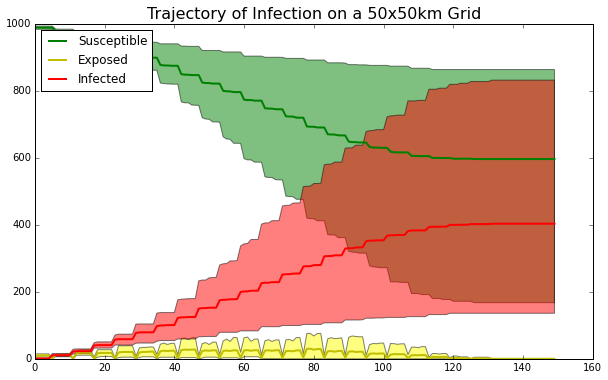

In [8]:
#Explore the trajectory of the disease
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10,6))

ax.plot(list(range(0,150)),mean_S,"g",lw = 2,label="Susceptible")
ax.fill_between(list(range(0,150)), LB_S, UB_S,facecolor='green',alpha=0.5)

ax.plot(list(range(0,150)),mean_E,"y",lw = 2,label="Exposed")
ax.fill_between(list(range(0,150)), LB_E, UB_E,facecolor='yellow',alpha=0.5)

ax.plot(list(range(0,150)),mean_I,"r",lw = 2,label="Infected")
ax.fill_between(list(range(0,150)), LB_I, UB_I,facecolor='red',alpha=0.5)

ax.legend(loc='upper left')
ax.set_title('Trajectory of Infection on a 50x50km Grid',fontsize=16)

In [8]:
test[2]

[1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 7,
 7,
 7,
 7,
 8,
 9,
 10,
 10,
 10,
 10,
 10,
 12,
 13,
 14,
 16,
 16,
 17,
 17,
 19,
 21,
 25,
 27,
 28,
 29,
 29,
 30,
 31,
 33,
 34,
 34,
 35,
 35,
 37,
 40,
 41,
 43,
 47,
 47,
 50,
 55,
 58,
 60,
 64,
 64,
 65,
 70,
 76,
 79,
 81,
 82,
 83,
 85,
 87,
 91,
 95,
 95,
 95,
 95,
 95,
 98,
 100,
 100,
 101,
 101,
 102,
 103,
 103,
 103,
 106,
 107,
 109,
 109,
 109,
 110,
 112,
 113,
 114,
 114,
 114,
 114,
 114,
 114,
 116,
 116,
 116,
 116,
 116,
 116,
 117,
 118,
 118,
 120,
 122,
 122,
 123,
 124,
 126,
 128,
 131,
 132,
 133,
 135,
 137,
 138,
 140,
 143,
 147,
 150,
 153,
 154,
 160,
 161,
 162,
 166,
 173,
 174,
 177,
 178,
 178,
 180,
 183,
 185,
 188,
 190,
 190,
 191,
 196,
 200,
 204,
 208,
 208,
 212,
 219,
 223,
 227,
 231,
 231,
 233,
 235,
 236,
 240,
 243,
 243,
 244,
 252,
 253,
 256,
 259,
 259,
 260,
 269,
 270,
 272,
 273,
 274,
 276,
 287,
 288,
 294,
 295,
 299,
 301,
 308,
 314,
 321,
 326,
 3